In [91]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime
import pandas as pd
import numpy as np

In [92]:
start = datetime.datetime(2020, 4, 25)
end = datetime.datetime(2021, 2, 25)

In [93]:
btc = web.DataReader('BTC-USD', 'yahoo', start, end)
eth = web.DataReader('ETH-USD', 'yahoo', start, end)
ada = web.DataReader('ADA-USD', 'yahoo', start, end)
bnb = web.DataReader('BNB-USD', 'yahoo', start, end)
dot = web.DataReader('DOT1-USD', 'yahoo', start, end)

In [94]:
coins = pd.concat([btc['Close'], eth['Close'], ada['Close'], bnb['Close'], dot['Close']], axis=1)
coins.columns = ['BTC', 'ETH', 'ADA', 'BNB', 'DOT']
returns = coins/coins.shift(1)
logReturns = np.log(returns)

In [95]:
noOfPortfolios = 10000
weight = np.zeros((noOfPortfolios, 5))

expectedReturn = np.zeros(noOfPortfolios)
expectedVolatility = np.zeros(noOfPortfolios)
sharpeRatio = np.zeros(noOfPortfolios)

meanLogRet = logReturns.mean()
Sigma = logReturns.cov()

for k in range(noOfPortfolios):
    # generate random weight vector
    w = np.array(np.random.random(5))
    w = w / np.sum(w)
    weight[k,:] = w
    
    # exepcted log return
    expectedReturn[k] = np.sum(meanLogRet * w)

    # excpected volatility
    expectedVolatility[k] = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    
    # shapre ratio
    sharpeRatio[k] = expectedReturn[k]/expectedVolatility[k]
    

In [96]:
maxIndex = sharpeRatio.argmax()
weight[maxIndex,:]

array([0.39494363, 0.00866209, 0.22269855, 0.11018581, 0.26350992])

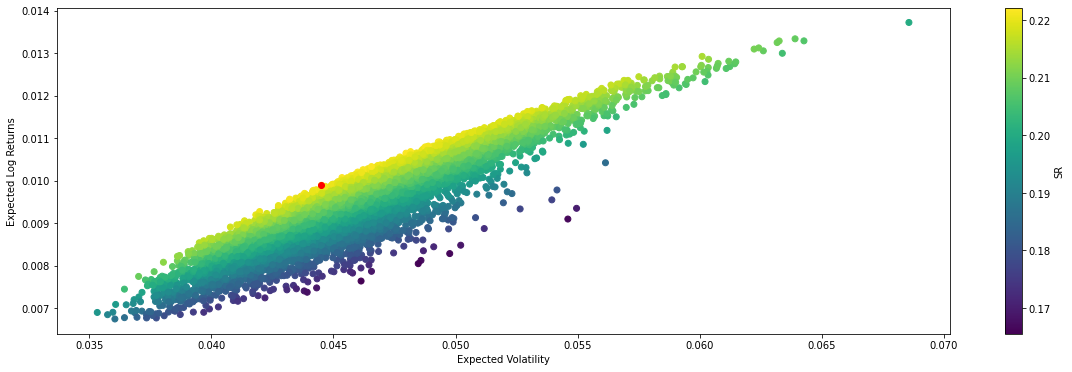

In [97]:
plt.figure(figsize=(20, 6))
plt.scatter(expectedVolatility, expectedReturn, c=sharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Returns')
plt.colorbar(label='SR')
plt.scatter(expectedVolatility[maxIndex], expectedReturn[maxIndex], c='red')
plt.show()

In [98]:
def negativeSR(w):
    w = np.array(w)
    R = np.sum(meanLogRet*w)
    V = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    SR = R/V
    return -1*SR

def checkSumToOne(w):
    return np.sum(w)-1

In [99]:
w0 = [0.25, 0.25, 0.25, 0.25, 0.25]
bounds = ((0, 1), (0, 1), (0, 1), (0, 1), (0, 1))
constraints = ({'type':'eq', 'fun':checkSumToOne})

In [100]:
w_opt = minimize(negativeSR, w0, method='SLSQP', bounds=bounds, constraints=constraints)
w_opt

     fun: -0.22262096246678506
     jac: array([-1.05960295e-04,  3.41590587e-02,  9.51010734e-05, -2.31668353e-04,
        1.72786415e-04])
 message: 'Optimization terminated successfully'
    nfev: 66
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([3.65481927e-01, 1.68322387e-17, 2.19871612e-01, 1.33083896e-01,
       2.81562566e-01])

In [103]:
alocs = w_opt.x*100

In [105]:
for coin, aloc in zip(coins.columns, alocs):
    print(f"Invest {aloc:.1f}% in {coin}")

Invest 36.5% in BTC
Invest 0.0% in ETH
Invest 22.0% in ADA
Invest 13.3% in BNB
Invest 28.2% in DOT
